In [1]:
import numpy as np
import pandas as pd 

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
from keras import regularizers

In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("2.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 0
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

#print("Summary of dataGene:\n",dataGene.describe())

In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in PCC feature selection method
feature_names = ['CoExpression', 'PCC', 'PPI', 'Root10DaysSeedling', 'Leaf21DaysSeedling',
                 'Leaf45DaysOldPlant', 'log_2FoldChange', 'ET', 'Shoot10DaysSeedling', 'Shoot3DaysSeedling', 
                 'Shoot35DaysSeedling', 'Shoot14DaysSeedling', 'Root17DaysSeedling', 'Shoot17DaysSeedling', 'Shoot21DaysSeedling',
                 'Root24DaysSeedling', 'Root14DaysSeedling', 'Root21DaysSeedling', 'Root52DaysSeedling', 'Root35DaysSeedling']

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
#print("Summary of X:\n",X.describe())
#print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray

X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)


Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
class
0.0      1800
1.0      1296
2.0      1260
3.0      1218
4.0      1026
5.0      1008
6.0       930
7.0       912
8.0       880
9.0       798
10.0      792
11.0      759
12.0      729
13.0      720
14.0      702
15.0      693
16.0      672
17.0      640
18.0      625
19.0      570
20.0      546
21.0      506
22.0      483
23.0      448
24.0      432
25.0      384
26.0      360
27.0      360
28.0      320
29.0      312
         ... 
343.0      12
344.0      12
345.0      12
346.0      12
347.0      12
348.0      12
349.0      12
350.0      12
351.0      12
352.0      12
353.0      12
354.0      12
355.0      11
356.0      11
357.0      11
358.0      11
359.0      11
360.0      11
361.0      10
362.0      10
363.0      10
364.0      10
365.0      10
366.0      10
367.0      10
368.0      10
369.0      10
370.0      10
371.0      10
372.0      10
Length: 373, dtype: int64


Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

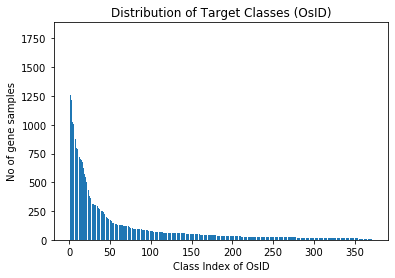

In [5]:
from collections import Counter
# summarize distribution
counter = Counter(Y.flatten())

# sort counter by keys
counter = dict(sorted(counter.items()))

for k,v in counter.items():
 per = v / len(Y.flatten()) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
def draw_confusion_matrix(cm):
    plt.figure(figsize=(12,8))
    sns.heatmap(cm,annot=True,fmt="d", center=0, cmap='autumn') 
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [7]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [8]:
# define baseline model (MLP)
def MLP_model(input_dim):

    model = Sequential()
    model.add(Dense(60, input_dim=input_dim,bias_initializer='normal', activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal', activation='softmax')) #softmax for multi-class classification, num_classes = 373

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [9]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

# Define the number of folds for k-fold cross-validation
k = 5

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = MLP_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=140, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape 

Number of input features: 1
Fold: 1
Epoch 1/140
2953/2953 [==============================] - 7s 2ms/step - loss: 5.0424 - accuracy: 0.0434 - val_loss: 4.9833 - val_accuracy: 0.0446
Epoch 2/140
2953/2953 [==============================] - 6s 2ms/step - loss: 4.9546 - accuracy: 0.0456 - val_loss: 4.9639 - val_accuracy: 0.0446
Epoch 3/140
2953/2953 [==============================] - 6s 2ms/step - loss: 4.9426 - accuracy: 0.0457 - val_loss: 4.9592 - val_accuracy: 0.0446
Epoch 4/140
2953/2953 [==============================] - 6s 2ms/step - loss: 4.9390 - accuracy: 0.0457 - val_loss: 4.9557 - val_accuracy: 0.0446
Epoch 5/140
2953/2953 [==============================] - 6s 2ms/step - loss: 4.9371 - accuracy: 0.0457 - val_loss: 4.9519 - val_accuracy: 0.0446
Epoch 6/140
2953/2953 [==============================] - 6s 2ms/step - loss: 4.9349 - accuracy: 0.0457 - val_loss: 4.9553 - val_accuracy: 0.0446
Epoch 7/140
2953/2953 [==============================] - 6s 2ms/step - loss: 4.9334 - accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 7s 2ms/step - loss: 5.0099 - accuracy: 0.0479 - val_loss: 4.9131 - val_accuracy: 0.0512
Epoch 2/140
2953/2953 [==============================] - 5s 2ms/step - loss: 4.8669 - accuracy: 0.0537 - val_loss: 4.8800 - val_accuracy: 0.0503
Epoch 3/140
2953/2953 [==============================] - 5s 2ms/step - loss: 4.8278 - accuracy: 0.0562 - val_loss: 4.8608 - val_accuracy: 0.0583
Epoch 4/140
2953/2953 [==============================] - 5s 2ms/step - loss: 4.7979 - accuracy: 0.0574 - val_loss: 4.8345 - val_accuracy: 0.0568
Epoch 5/140
2953/2953 [==============================] - 5s 2ms/step - loss: 4.7772 - accuracy: 0.0595 - val_loss: 4.8362 - val_accuracy: 0.0626
Epoch 6/140
2953/2953 [==============================] - 6s 2ms/step - loss: 4.7626 - accuracy: 0.0610 - val_loss: 4.8270 - val_accuracy: 0.0589
Epoch 7/140
2953/2953 [==============================] - 5s 2ms/step - loss: 4.7488 - accuracy: 0.0594 - val_loss: 4.8320 - val_accuracy: 0.06

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 7s 2ms/step - loss: 4.8700 - accuracy: 0.0702 - val_loss: 4.7024 - val_accuracy: 0.0814
Epoch 2/140
2953/2953 [==============================] - 5s 2ms/step - loss: 4.6120 - accuracy: 0.0832 - val_loss: 4.6203 - val_accuracy: 0.0814
Epoch 3/140
2953/2953 [==============================] - 5s 2ms/step - loss: 4.5490 - accuracy: 0.0844 - val_loss: 4.5970 - val_accuracy: 0.0781
Epoch 4/140
2953/2953 [==============================] - 5s 2ms/step - loss: 4.5198 - accuracy: 0.0844 - val_loss: 4.5712 - val_accuracy: 0.0851
Epoch 5/140
2953/2953 [==============================] - 5s 2ms/step - loss: 4.4983 - accuracy: 0.0858 - val_loss: 4.5723 - val_accuracy: 0.0813
Epoch 6/140
2953/2953 [==============================] - 5s 2ms/step - loss: 4.4837 - accuracy: 0.0851 - val_loss: 4.5653 - val_accuracy: 0.0777
Epoch 7/140
2953/2953 [==============================] - 5s 2ms/step - loss: 4.4709 - accuracy: 0.0863 - val_loss: 4.5705 - val_accuracy: 0.08

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 7s 2ms/step - loss: 4.0858 - accuracy: 0.1626 - val_loss: 3.4514 - val_accuracy: 0.2622
Epoch 2/140
2953/2953 [==============================] - 5s 2ms/step - loss: 3.1238 - accuracy: 0.2945 - val_loss: 2.9918 - val_accuracy: 0.2941
Epoch 3/140
2953/2953 [==============================] - 5s 2ms/step - loss: 2.7610 - accuracy: 0.3288 - val_loss: 2.7510 - val_accuracy: 0.3563
Epoch 4/140
2953/2953 [==============================] - 5s 2ms/step - loss: 2.5559 - accuracy: 0.3594 - val_loss: 2.5948 - val_accuracy: 0.3570
Epoch 5/140
2953/2953 [==============================] - 5s 2ms/step - loss: 2.4219 - accuracy: 0.3787 - val_loss: 2.5694 - val_accuracy: 0.3516
Epoch 6/140
2953/2953 [==============================] - 5s 2ms/step - loss: 2.3257 - accuracy: 0.3928 - val_loss: 2.5394 - val_accuracy: 0.4040
Epoch 7/140
2953/2953 [==============================] - 5s 2ms/step - loss: 2.2625 - accuracy: 0.4054 - val_loss: 2.3811 - val_accuracy: 0.40

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 7s 2ms/step - loss: 3.9217 - accuracy: 0.2105 - val_loss: 3.2584 - val_accuracy: 0.3155
Epoch 2/140
2953/2953 [==============================] - 6s 2ms/step - loss: 2.7875 - accuracy: 0.3562 - val_loss: 2.6062 - val_accuracy: 0.4135
Epoch 3/140
2953/2953 [==============================] - 5s 2ms/step - loss: 2.2183 - accuracy: 0.4396 - val_loss: 2.2256 - val_accuracy: 0.4589
Epoch 4/140
2953/2953 [==============================] - 6s 2ms/step - loss: 1.8804 - accuracy: 0.4984 - val_loss: 1.9751 - val_accuracy: 0.4796
Epoch 5/140
2953/2953 [==============================] - 5s 2ms/step - loss: 1.6772 - accuracy: 0.5369 - val_loss: 1.8145 - val_accuracy: 0.5190
Epoch 6/140
2953/2953 [==============================] - 5s 2ms/step - loss: 1.5465 - accuracy: 0.5619 - val_loss: 1.7171 - val_accuracy: 0.5334
Epoch 7/140
2953/2953 [==============================] - 6s 2ms/step - loss: 1.4746 - accuracy: 0.5698 - val_loss: 1.5888 - val_accuracy: 0.56

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 7s 2ms/step - loss: 3.6862 - accuracy: 0.2679 - val_loss: 2.4616 - val_accuracy: 0.4902
Epoch 2/140
2953/2953 [==============================] - 6s 2ms/step - loss: 1.8107 - accuracy: 0.5920 - val_loss: 1.5302 - val_accuracy: 0.6504
Epoch 3/140
2953/2953 [==============================] - 5s 2ms/step - loss: 1.1790 - accuracy: 0.7024 - val_loss: 1.1524 - val_accuracy: 0.7226
Epoch 4/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.9183 - accuracy: 0.7523 - val_loss: 0.9683 - val_accuracy: 0.7728
Epoch 5/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.7804 - accuracy: 0.7809 - val_loss: 0.8569 - val_accuracy: 0.7864
Epoch 6/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.6966 - accuracy: 0.8002 - val_loss: 0.8249 - val_accuracy: 0.7968
Epoch 7/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.6377 - accuracy: 0.8143 - val_loss: 0.6834 - val_accuracy: 0.81

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 6s 2ms/step - loss: 3.6270 - accuracy: 0.2770 - val_loss: 2.5717 - val_accuracy: 0.4725
Epoch 2/140
2953/2953 [==============================] - 5s 2ms/step - loss: 1.9382 - accuracy: 0.5696 - val_loss: 1.6969 - val_accuracy: 0.6196
Epoch 3/140
2953/2953 [==============================] - 5s 2ms/step - loss: 1.2560 - accuracy: 0.6937 - val_loss: 1.2320 - val_accuracy: 0.7280
Epoch 4/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.9272 - accuracy: 0.7565 - val_loss: 0.9967 - val_accuracy: 0.7588
Epoch 5/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.7599 - accuracy: 0.7922 - val_loss: 0.8917 - val_accuracy: 0.7917
Epoch 6/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.6477 - accuracy: 0.8176 - val_loss: 0.7910 - val_accuracy: 0.8067
Epoch 7/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.5795 - accuracy: 0.8323 - val_loss: 0.6861 - val_accuracy: 0.82

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 6s 2ms/step - loss: 3.6071 - accuracy: 0.2322 - val_loss: 2.4175 - val_accuracy: 0.4145
Epoch 2/140
2953/2953 [==============================] - 5s 2ms/step - loss: 1.7906 - accuracy: 0.5839 - val_loss: 1.6322 - val_accuracy: 0.6265
Epoch 3/140
2953/2953 [==============================] - 5s 2ms/step - loss: 1.1655 - accuracy: 0.7033 - val_loss: 1.1589 - val_accuracy: 0.7298
Epoch 4/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.8959 - accuracy: 0.7494 - val_loss: 0.9669 - val_accuracy: 0.7672
Epoch 5/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.7563 - accuracy: 0.7811 - val_loss: 0.8369 - val_accuracy: 0.7748
Epoch 6/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.6593 - accuracy: 0.8052 - val_loss: 0.7426 - val_accuracy: 0.8166
Epoch 7/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.6074 - accuracy: 0.8159 - val_loss: 0.7157 - val_accuracy: 0.80

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 6s 2ms/step - loss: 3.2086 - accuracy: 0.3687 - val_loss: 1.9140 - val_accuracy: 0.6411
Epoch 2/140
2953/2953 [==============================] - 5s 2ms/step - loss: 1.2943 - accuracy: 0.7283 - val_loss: 1.0952 - val_accuracy: 0.7658
Epoch 3/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.7598 - accuracy: 0.8146 - val_loss: 0.8278 - val_accuracy: 0.8084
Epoch 4/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.5594 - accuracy: 0.8523 - val_loss: 0.6190 - val_accuracy: 0.8623
Epoch 5/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.4627 - accuracy: 0.8707 - val_loss: 0.5883 - val_accuracy: 0.8553
Epoch 6/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.4087 - accuracy: 0.8837 - val_loss: 0.4790 - val_accuracy: 0.8744
Epoch 7/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.3642 - accuracy: 0.8955 - val_loss: 0.3916 - val_accuracy: 0.89

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 7s 2ms/step - loss: 3.0045 - accuracy: 0.4274 - val_loss: 1.7206 - val_accuracy: 0.6781
Epoch 2/140
2953/2953 [==============================] - 6s 2ms/step - loss: 1.1378 - accuracy: 0.7596 - val_loss: 0.9611 - val_accuracy: 0.8126
Epoch 3/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.6447 - accuracy: 0.8439 - val_loss: 0.6605 - val_accuracy: 0.8681
Epoch 4/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.4647 - accuracy: 0.8789 - val_loss: 0.5381 - val_accuracy: 0.8914
Epoch 5/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.3721 - accuracy: 0.9017 - val_loss: 0.4477 - val_accuracy: 0.8948
Epoch 6/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.3202 - accuracy: 0.9127 - val_loss: 0.4340 - val_accuracy: 0.8947
Epoch 7/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.2889 - accuracy: 0.9216 - val_loss: 0.3015 - val_accuracy: 0.93

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 7s 2ms/step - loss: 2.9086 - accuracy: 0.4617 - val_loss: 1.4875 - val_accuracy: 0.7364
Epoch 2/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.9157 - accuracy: 0.8149 - val_loss: 0.7676 - val_accuracy: 0.8549
Epoch 3/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.4899 - accuracy: 0.8875 - val_loss: 0.5265 - val_accuracy: 0.8944
Epoch 4/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.3341 - accuracy: 0.9160 - val_loss: 0.4246 - val_accuracy: 0.9120
Epoch 5/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.2592 - accuracy: 0.9353 - val_loss: 0.3164 - val_accuracy: 0.9444
Epoch 6/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.2202 - accuracy: 0.9458 - val_loss: 0.2772 - val_accuracy: 0.9354
Epoch 7/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.1893 - accuracy: 0.9541 - val_loss: 0.2311 - val_accuracy: 0.94

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 7s 2ms/step - loss: 2.8624 - accuracy: 0.4631 - val_loss: 1.5121 - val_accuracy: 0.7262
Epoch 2/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.9519 - accuracy: 0.8214 - val_loss: 0.8079 - val_accuracy: 0.8515
Epoch 3/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.4952 - accuracy: 0.8938 - val_loss: 0.5085 - val_accuracy: 0.8987
Epoch 4/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.3361 - accuracy: 0.9218 - val_loss: 0.4136 - val_accuracy: 0.9138
Epoch 5/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.2642 - accuracy: 0.9365 - val_loss: 0.3342 - val_accuracy: 0.9274
Epoch 6/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.2253 - accuracy: 0.9467 - val_loss: 0.2679 - val_accuracy: 0.9381
Epoch 7/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.2040 - accuracy: 0.9503 - val_loss: 0.2104 - val_accuracy: 0.95

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 7s 2ms/step - loss: 2.7242 - accuracy: 0.5026 - val_loss: 1.2678 - val_accuracy: 0.7950
Epoch 2/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.7518 - accuracy: 0.8564 - val_loss: 0.5867 - val_accuracy: 0.8765
Epoch 3/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.3706 - accuracy: 0.9130 - val_loss: 0.4112 - val_accuracy: 0.9146
Epoch 4/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.2646 - accuracy: 0.9339 - val_loss: 0.3069 - val_accuracy: 0.9266
Epoch 5/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.2094 - accuracy: 0.9465 - val_loss: 0.2398 - val_accuracy: 0.9416
Epoch 6/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.1883 - accuracy: 0.9504 - val_loss: 0.1999 - val_accuracy: 0.9449
Epoch 7/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.1613 - accuracy: 0.9592 - val_loss: 0.2522 - val_accuracy: 0.93

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/140
2953/2953 [==============================] - 7s 2ms/step - loss: 2.8886 - accuracy: 0.4562 - val_loss: 1.6123 - val_accuracy: 0.6995
Epoch 2/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.9991 - accuracy: 0.8082 - val_loss: 0.7945 - val_accuracy: 0.8412
Epoch 3/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.4949 - accuracy: 0.8896 - val_loss: 0.5382 - val_accuracy: 0.9064
Epoch 4/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.3188 - accuracy: 0.9229 - val_loss: 0.3945 - val_accuracy: 0.9267
Epoch 5/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.2473 - accuracy: 0.9400 - val_loss: 0.3384 - val_accuracy: 0.9326
Epoch 6/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.2064 - accuracy: 0.9484 - val_loss: 0.2512 - val_accuracy: 0.9464
Epoch 7/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.1824 - accuracy: 0.9545 - val_loss: 0.2241 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/140
2953/2953 [==============================] - 7s 2ms/step - loss: 2.7971 - accuracy: 0.4833 - val_loss: 1.4289 - val_accuracy: 0.7547
Epoch 2/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.8688 - accuracy: 0.8335 - val_loss: 0.7475 - val_accuracy: 0.8681
Epoch 3/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.4654 - accuracy: 0.8992 - val_loss: 0.5238 - val_accuracy: 0.8960
Epoch 4/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.3214 - accuracy: 0.9203 - val_loss: 0.3964 - val_accuracy: 0.9120
Epoch 5/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.2576 - accuracy: 0.9366 - val_loss: 0.3716 - val_accuracy: 0.9233
Epoch 6/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.2151 - accuracy: 0.9451 - val_loss: 0.2686 - val_accuracy: 0.9410
Epoch 7/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.1881 - accuracy: 0.9545 - val_loss: 0.2329 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 8s 2ms/step - loss: 2.6653 - accuracy: 0.4950 - val_loss: 1.4272 - val_accuracy: 0.7675
Epoch 2/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.8350 - accuracy: 0.8367 - val_loss: 0.7325 - val_accuracy: 0.8727
Epoch 3/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.4402 - accuracy: 0.9013 - val_loss: 0.5098 - val_accuracy: 0.9062
Epoch 4/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.2987 - accuracy: 0.9292 - val_loss: 0.4158 - val_accuracy: 0.9114
Epoch 5/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.2395 - accuracy: 0.9411 - val_loss: 0.2939 - val_accuracy: 0.9384
Epoch 6/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.2008 - accuracy: 0.9482 - val_loss: 0.2254 - val_accuracy: 0.9542
Epoch 7/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.1781 - accuracy: 0.9545 - val_loss: 0.3664 - val_accuracy: 0.92

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 8s 2ms/step - loss: 2.5274 - accuracy: 0.5293 - val_loss: 1.2758 - val_accuracy: 0.7819
Epoch 2/140
2953/2953 [==============================] - 7s 2ms/step - loss: 0.7577 - accuracy: 0.8427 - val_loss: 0.6233 - val_accuracy: 0.8822
Epoch 3/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.3835 - accuracy: 0.9076 - val_loss: 0.4418 - val_accuracy: 0.9124
Epoch 4/140
2953/2953 [==============================] - 7s 2ms/step - loss: 0.2743 - accuracy: 0.9306 - val_loss: 0.4330 - val_accuracy: 0.8889
Epoch 5/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.2229 - accuracy: 0.9435 - val_loss: 0.3866 - val_accuracy: 0.8845
Epoch 6/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.1908 - accuracy: 0.9498 - val_loss: 0.2193 - val_accuracy: 0.9372
Epoch 7/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.1739 - accuracy: 0.9548 - val_loss: 0.1962 - val_accuracy: 0.95

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/140
2953/2953 [==============================] - 8s 2ms/step - loss: 3.0859 - accuracy: 0.4174 - val_loss: 1.5656 - val_accuracy: 0.7211
Epoch 2/140
2953/2953 [==============================] - 7s 2ms/step - loss: 1.0007 - accuracy: 0.8086 - val_loss: 0.8424 - val_accuracy: 0.8570
Epoch 3/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.5304 - accuracy: 0.8912 - val_loss: 0.5511 - val_accuracy: 0.9013
Epoch 4/140
2953/2953 [==============================] - 7s 2ms/step - loss: 0.3395 - accuracy: 0.9220 - val_loss: 0.4110 - val_accuracy: 0.9168
Epoch 5/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.2565 - accuracy: 0.9405 - val_loss: 0.3151 - val_accuracy: 0.9429
Epoch 6/140
2953/2953 [==============================] - 7s 2ms/step - loss: 0.2134 - accuracy: 0.9491 - val_loss: 0.3081 - val_accuracy: 0.9398
Epoch 7/140
2953/2953 [==============================] - 7s 2ms/step - loss: 0.1856 - accuracy: 0.9557 - val_loss: 0.2224 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 9s 2ms/step - loss: 2.7860 - accuracy: 0.4958 - val_loss: 1.4355 - val_accuracy: 0.7310
Epoch 2/140
2953/2953 [==============================] - 7s 2ms/step - loss: 0.9090 - accuracy: 0.8248 - val_loss: 0.7076 - val_accuracy: 0.8714
Epoch 3/140
2953/2953 [==============================] - 7s 2ms/step - loss: 0.4683 - accuracy: 0.8997 - val_loss: 0.4609 - val_accuracy: 0.9105
Epoch 4/140
2953/2953 [==============================] - 7s 2ms/step - loss: 0.3054 - accuracy: 0.9272 - val_loss: 0.3418 - val_accuracy: 0.9286
Epoch 5/140
2953/2953 [==============================] - 7s 2ms/step - loss: 0.2320 - accuracy: 0.9447 - val_loss: 0.3248 - val_accuracy: 0.9209
Epoch 6/140
2953/2953 [==============================] - 7s 2ms/step - loss: 0.1916 - accuracy: 0.9545 - val_loss: 0.2524 - val_accuracy: 0.9391
Epoch 7/140
2953/2953 [==============================] - 7s 2ms/step - loss: 0.1708 - accuracy: 0.9594 - val_loss: 0.1805 - val_accuracy: 0.96

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 9s 3ms/step - loss: 2.6523 - accuracy: 0.5045 - val_loss: 1.3836 - val_accuracy: 0.7655
Epoch 2/140
2953/2953 [==============================] - 7s 2ms/step - loss: 0.8710 - accuracy: 0.8300 - val_loss: 0.7498 - val_accuracy: 0.8782
Epoch 3/140
2953/2953 [==============================] - 7s 2ms/step - loss: 0.4335 - accuracy: 0.9064 - val_loss: 0.4676 - val_accuracy: 0.9095
Epoch 4/140
2953/2953 [==============================] - 7s 2ms/step - loss: 0.2784 - accuracy: 0.9334 - val_loss: 0.3566 - val_accuracy: 0.9380
Epoch 5/140
2953/2953 [==============================] - 7s 2ms/step - loss: 0.2198 - accuracy: 0.9471 - val_loss: 0.2862 - val_accuracy: 0.9447
Epoch 6/140
2953/2953 [==============================] - 7s 2ms/step - loss: 0.1873 - accuracy: 0.9542 - val_loss: 0.2518 - val_accuracy: 0.9405
Epoch 7/140
2953/2953 [==============================] - 7s 2ms/step - loss: 0.1609 - accuracy: 0.9617 - val_loss: 0.1951 - val_accuracy: 0.95

In [10]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

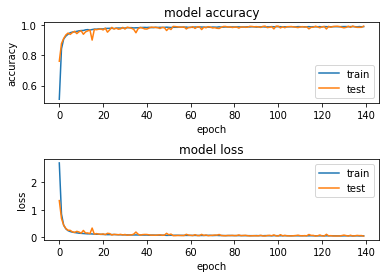

Final Test Accuracy: 0.9938822388648987


In [11]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [12]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))


424/424 [==============================] - 5s 10ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       1.00      1.00      1.00       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       1.00      1.00      1.00       294
           9       1.00      1.00      1.00       269
          10       1.00      1.00      1.00       296
          11       1.00      1.00      1.00       258
          12       1.00      1.00      1.00       247
          13       1.00      1.00      1.00       237
          14       1.00      1.00      1.00       239
          15       1.00      1.00      1.00       235
 

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [13]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os11g0704500         329              329        True
1  Os09g0279600         161              161        True
2  Os03g0669100          17               17        True
3  Os05g0542500          34               34        True
4  Os09g0522000           7                7        True


In [14]:
print(models_df)

    No of input features  Model accuracy
0                      1           0.045
1                      2           0.091
2                      3           0.121
3                      4           0.607
4                      5           0.834
5                      6           0.954
6                      7           0.976
7                      8           0.966
8                      9           0.987
9                     10           0.988
10                    11           0.992
11                    12           0.991
12                    13           0.993
13                    14           0.993
14                    15           0.990
15                    16           0.993
16                    17           0.994
17                    18           0.992
18                    19           0.992
19                    20           0.992
